In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'

import pandas
import numpy
import statsmodels.graphics.tsaplots as tsaplots
import statsmodels.graphics.gofplots as gofplots
import statsmodels.formula.api as sm
import datetime

COLOR_REP = '#E24A33'
COLOR_DEM = '#348ABD'
COLOR_ALT = '#777777'

# Introduction

This document shows how to do some basic analysis on the data that we gathered in `all_data.csv`. In particular, we are trying to see if correlations exist between the political composition of the presidency, the senate, or the house, and economic indicators such as GDP, federal surplus, and amount of defense spending.

# Data

## Reading Data

We read the data from a `.csv` into a DataFrame below and see rows and rows of data -- each row containing data for a single year. That's simple enough.

In [3]:
data = pandas.read_csv('all_data.csv', index_col='date', parse_dates=True)

In [4]:
data

,dem_pres,total_senate,dem_senate,rep_senate,total_house,dem_house,rep_house,gdp_r,gdp_n,cpi,fed_sur,fed_rec,fed_out,def_pct_gdp,cpi_inflation,gdp_r_growth,gdp_n_growth,fed_sur_pct_gdp
date,,,,,,,,,,,,,,,,,,
1930-01-01,0,96,39,56,435,163,267,966.7,92.2,17.100,738.0,4058.0,3320.0,1.2,0.000000,-0.085084,-0.118547,8.004338
1931-01-01,0,96,39,56,435,163,267,904.8,77.4,15.900,-462.0,3116.0,3577.0,1.4,-0.070175,-0.064032,-0.160521,-5.968992
1932-01-01,0,96,47,48,435,217,217,788.2,59.5,14.300,-2735.0,1924.0,4659.0,1.7,-0.100629,-0.128868,-0.231266,-45.966387
1933-01-01,1,96,47,48,435,217,217,778.3,57.2,12.900,-2602.0,1997.0,4598.0,1.7,-0.097902,-0.012560,-0.038655,-45.489510
1934-01-01,1,96,59,36,435,313,117,862.2,66.8,13.200,-3586.0,2955.0,6541.0,1.4,0.023256,0.107799,0.167832,-53.682635
1935-01-01,1,96,59,36,435,313,117,939.0,74.3,13.600,-2803.0,3609.0,6412.0,1.6,0.030303,0.089074,0.112275,-37.725437
1936-01-01,1,96,69,25,435,322,103,1060.5,84.9,13.800,-4304.0,3923.0,8228.0,1.6,0.014706,0.129393,0.142665,-50.694935
1937-01-01,1,96,69,25,435,322,103,1114.6,93.0,14.100,-2193.0,5387.0,7580.0,1.5,0.021739,0.051014,0.095406,-23.580645
1938-01-01,1,96,75,17,435,333,89,1077.7,87.4,14.200,-89.0,6751.0,6840.0,1.7,0.007092,-0.033106,-0.060215,-1.018307


## Verifying Data

However, we're not ready to use the data yet. A big part of being an economist is to never trust the data. For all you know, the data may be collected by a sleepy sophomore year undergrad research assistant.

Being the untrusting cynics that we are, we should interrogate the data to verify that it is truly what it says it is. In other words, we check that the data makes sense intuitively. We can do this in a variety of ways. We demonstrate some of the most common ones below.

First, it'd be really useful to plot similar data. In our case, we have both **real** GDP (`gdp_r`) and **nominal** GDP (`gdp_n`) in the data. So we plot them both below:

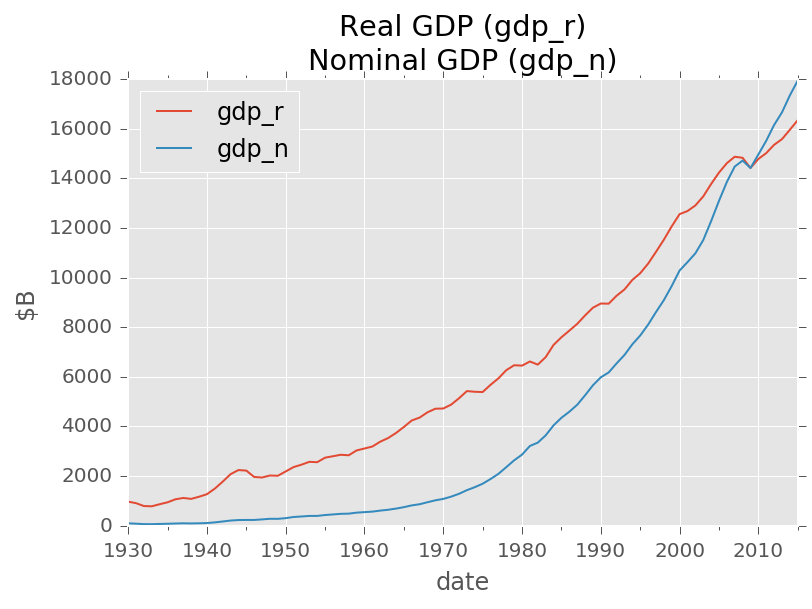

In [5]:
data[['gdp_r', 'gdp_n']].plot()
plt.title('Real GDP (gdp_r)\nNominal GDP (gdp_n)')
plt.ylabel('$B')
plt.show()

Now let's see if what we see above makes sense. We were told by FRED that real GDP is denominated in 2009 dollars. This means that the real and nominal GDP in 2009 should be the same. So that feature exists in the graph above. We also know that if inflation is positive (as it is most of the time), real GDP should lie **above** nominal GDP before 2009 and **below** nominal GDP after 2009. That's true for the graph above as well. Furthermore, the dimensions of the numbers (e.g. around \$15,000B in 2009) makes sense.

We can do the same for the two growth columns: `gdp_r_growth` representing real GDP growth and `gdp_n_growth` representing nominal GDP growth. Since $(1+N) = (1+R)(1+i)$ where $N$ is nominal GDP growth, $R$ is real GDP growth, and $i$ is inflation, then if inflation is positive most of the time, real GDP growth should be below nominal GDP growth. Again, this is the case for the graph below.

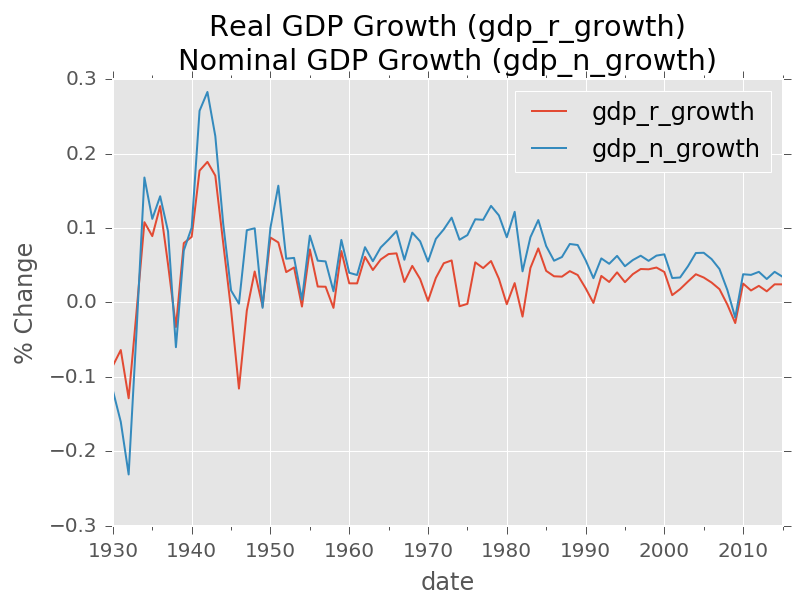

In [6]:
data[['gdp_r_growth', 'gdp_n_growth']].plot()
plt.title('Real GDP Growth (gdp_r_growth)\nNominal GDP Growth (gdp_n_growth)')
plt.ylabel('% Change')
plt.show()

We can also do a *checksum* on the columns. For example, by definition, federal surplus is the difference between the amount received by the federal government (federal receipt) and the amount spent (federal outlay). We have all three columns in the data: `fed_rec` for federal receipts, `fed_out` for federal outlays, `fed_sur` for federal surplus. We plot all three of them and see that it indeed looks like `fed_sur = fed_rec - fed_out`.

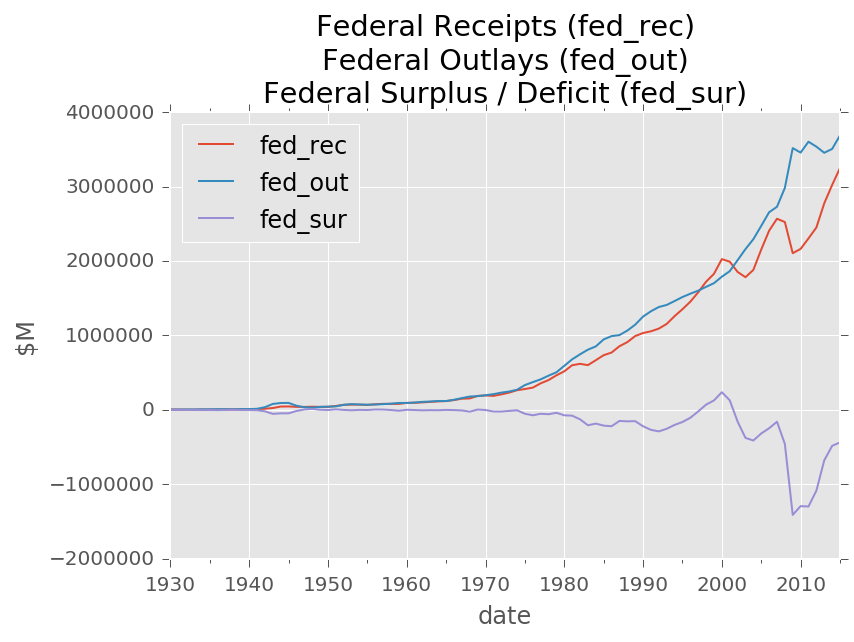

In [7]:
data[['fed_rec', 'fed_out', 'fed_sur']].plot()
plt.title('Federal Receipts (fed_rec)\nFederal Outlays (fed_out)\nFederal Surplus / Deficit (fed_sur)')
plt.ylabel('$M')
plt.show()

We can verify this by plotting `fed_sur` on the top graph and `fed_rec - fed_out` in the bottom graph.

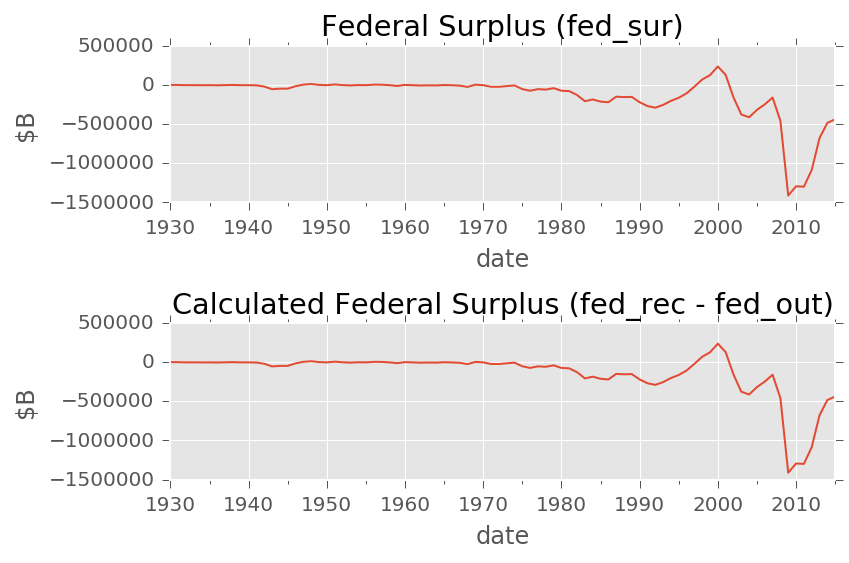

In [8]:
plt.subplot(2, 1, 1)
data['fed_sur'].plot()
plt.ylabel('$B')
plt.title('Federal Surplus (fed_sur)')
plt.subplot(2, 1, 2)
(data['fed_rec'] - data['fed_out']).plot()
plt.ylabel('$B')
plt.title('Calculated Federal Surplus (fed_rec - fed_out)')
plt.tight_layout()

We can also check that the data makes economic sense. For example, we have a column for Consumer Price Index (CPI). The rate of change of this should *roughly* correspond to inflation in each year. In that case, $\text{CPI} \approx \frac{\text{Nominal GDP}}{\text{Real GDP}}$. We plot both and find that they indeed look alike.

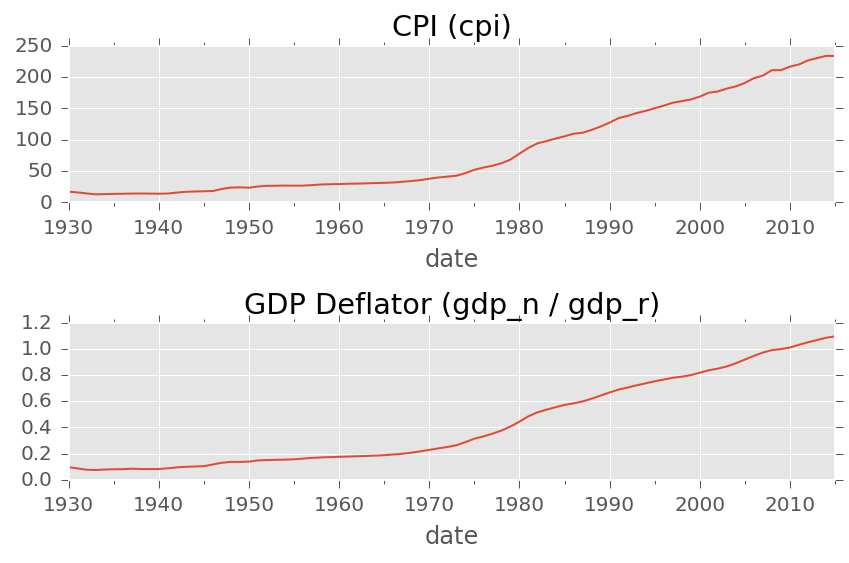

In [9]:
plt.subplot(2, 1, 1)
data['cpi'].plot()
plt.title('CPI (cpi)')
plt.subplot(2, 1, 2)
(data['gdp_n'] / data['gdp_r']).plot()
plt.title('GDP Deflator (gdp_n / gdp_r)')
plt.tight_layout()

> The sharper ones among us may realize that they're not exactly equal. Indeed, that is the case. $\frac{\text{Nominal GDP}}{\text{Real GDP}}$ gives us the **GDP deflator**, which is the proportion by which nominal GDP differs from real GDP. That is different from the consumer price index in two ways:
> 1. GDP deflator includes only domestic goods and not anything that is imported. CPI on the other hand includes anything bought by consumers including foreign goods.
> 2. GDP deflator is a measure of the prices of all goods and services while the CPI is a measure of only goods bought by consumers.

We can also plot the lines with nicely colored backgrounds to differentiate between Democratic / Republican years.

In [6]:
def plot_line_with_background(line_data_name, background_binary_name, dataframe, title, ylabel):
    dataframe[line_data_name].plot(color=COLOR_ALT)
    if numpy.max(dataframe[line_data_name]) > 0:
        plt.bar(dataframe.index, dataframe[background_binary_name] * numpy.max(dataframe[line_data_name]), color=COLOR_DEM, align='center', alpha=0.2)
        plt.bar(dataframe.index, (1 - dataframe[background_binary_name]) * numpy.max(dataframe[line_data_name]), color=COLOR_REP, align='center', alpha=0.2)
    if numpy.min(dataframe[line_data_name]) < 0:
        plt.bar(dataframe.index, dataframe[background_binary_name] * numpy.min(dataframe[line_data_name]), color=COLOR_DEM, align='center', alpha=0.2)
        plt.bar(dataframe.index, (1 - dataframe[background_binary_name]) * numpy.min(dataframe[line_data_name]), color=COLOR_REP, align='center', alpha=0.2)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.show()

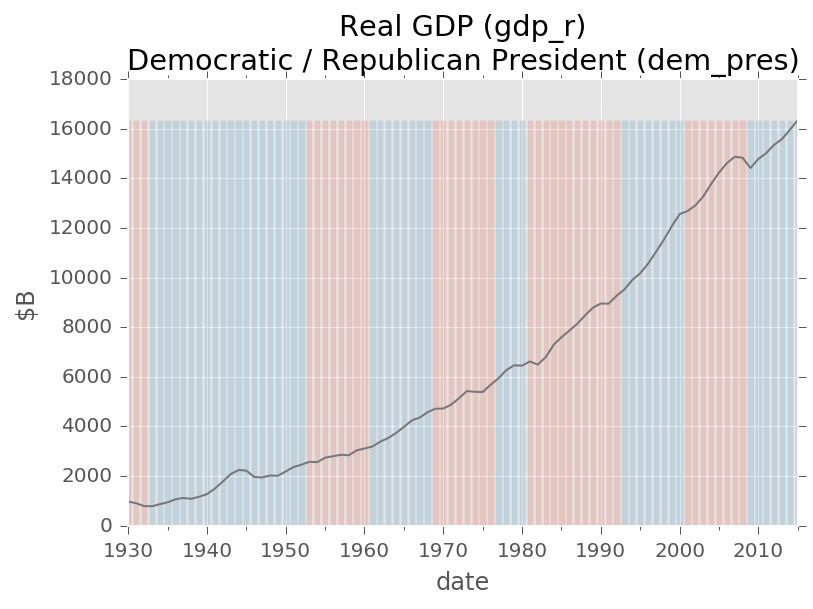

In [11]:
plot_line_with_background('gdp_r', 'dem_pres', data, 'Real GDP (gdp_r)\nDemocratic / Republican President (dem_pres)', '$B')

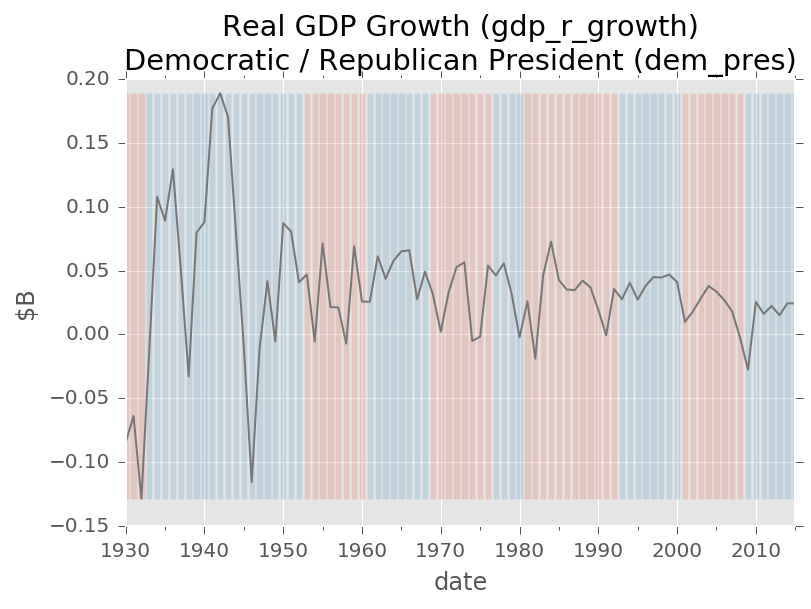

In [12]:
plot_line_with_background('gdp_r_growth', 'dem_pres', data, 
                          'Real GDP Growth (gdp_r_growth)\nDemocratic / Republican President (dem_pres)', '$B')

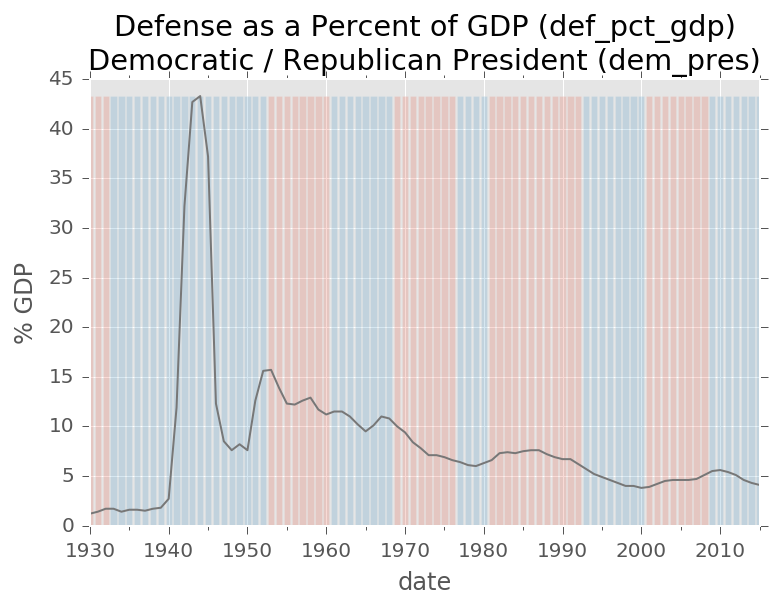

In [13]:
plot_line_with_background('def_pct_gdp', 'dem_pres', data, 
                          'Defense as a Percent of GDP (def_pct_gdp)\nDemocratic / Republican President (dem_pres)',
                          '% GDP')

Now ain't that pretty.

# Analysis

## Derived Data

We calculte some derived data columns (derived from the existing data). First, we lag real GDP growth `gdp_r_growth` by 1 year. The use of these lagged variables will be shown later.

In [7]:
data['gdp_r_growth_lag1'] = data['gdp_r'].pct_change().shift(1)

We do the same for defense as a percent of GDP `def_pct_gdp`.

In [8]:
data['def_pct_gdp_lag1'] = data['def_pct_gdp'].pct_change().shift(1)
data['def_pct_gdp_lag2'] = data['def_pct_gdp'].pct_change().shift(2)

We also create a column showing the **difference** between federal surplus as a percent of GDP between years. Note that this is the absolute difference, not percent change.

In [9]:
data['fed_sur_pct_gdp_growth'] = data['fed_sur_pct_gdp'].diff()

We also create dummy variables for `great_depression` and `ww2` indicating the years which fall into those periods. This is useful for multivariate regressions.

In [10]:
data['great_depression'] = 0
data['great_depression'][data.index < datetime.datetime(1938, 1, 1)] = 1
data['ww2'] = 0
data['ww2'][(data.index < datetime.datetime(1946, 1, 1)) & (data.index > datetime.datetime(1939, 1, 1))] = 1

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


We also calculate the percent of senate / house being democrats and indicators for majority.

In [56]:
data['dem_senate_pct'] = data['dem_senate'] / data['total_senate']
data['dem_house_pct'] = data['dem_house'] / data['total_house']
data['dem_senate_maj'] = data['dem_senate_pct'] > 0.5
data['dem_house_maj'] = data['dem_house_pct'] > 0.5

The new dataframe with the additional derived columns look like this. Note the `NaN`s that exist in the first few rows of `gdp_r_growth_lagX`, `def_pct_gdp_lagX`, and `fed_sur_pct_gdp_growth`. They exist because of insufficient data -- it is not possible to know the lagged growth of the first year for a variable that is lagged one year.

In [12]:
data

,dem_pres,total_senate,dem_senate,rep_senate,total_house,dem_house,rep_house,gdp_r,gdp_n,cpi,...,gdp_n_growth,fed_sur_pct_gdp,gdp_r_growth_lag1,def_pct_gdp_lag1,def_pct_gdp_lag2,fed_sur_pct_gdp_growth,great_depression,ww2,dem_senate_pct,dem_house_pct
date,,,,,,,,,,,,,,,,,,,,,
1930-01-01,0,96,39,56,435,163,267,966.7,92.2,17.100,...,-0.118547,8.004338,NaN,NaN,NaN,NaN,1,0,0.406250,0.374713
1931-01-01,0,96,39,56,435,163,267,904.8,77.4,15.900,...,-0.160521,-5.968992,NaN,NaN,NaN,-13.973331,1,0,0.406250,0.374713
1932-01-01,0,96,47,48,435,217,217,788.2,59.5,14.300,...,-0.231266,-45.966387,-0.064032,0.166667,NaN,-39.997394,1,0,0.489583,0.498851
1933-01-01,1,96,47,48,435,217,217,778.3,57.2,12.900,...,-0.038655,-45.489510,-0.128868,0.214286,0.166667,0.476876,1,0,0.489583,0.498851
1934-01-01,1,96,59,36,435,313,117,862.2,66.8,13.200,...,0.167832,-53.682635,-0.012560,0.000000,0.214286,-8.193124,1,0,0.614583,0.719540
1935-01-01,1,96,59,36,435,313,117,939.0,74.3,13.600,...,0.112275,-37.725437,0.107799,-0.176471,0.000000,15.957197,1,0,0.614583,0.719540
1936-01-01,1,96,69,25,435,322,103,1060.5,84.9,13.800,...,0.142665,-50.694935,0.089074,0.142857,-0.176471,-12.969498,1,0,0.718750,0.740230
1937-01-01,1,96,69,25,435,322,103,1114.6,93.0,14.100,...,0.095406,-23.580645,0.129393,0.000000,0.142857,27.114290,1,0,0.718750,0.740230
1938-01-01,1,96,75,17,435,333,89,1077.7,87.4,14.200,...,-0.060215,-1.018307,0.051014,-0.062500,0.000000,22.562339,0,0,0.781250,0.765517


We need to drop rows (delete rows) with these `NaN`s.

In [53]:
data = data.dropna()
data

,dem_pres,total_senate,dem_senate,rep_senate,total_house,dem_house,rep_house,gdp_r,gdp_n,cpi,...,gdp_r_growth_lag1,def_pct_gdp_lag1,def_pct_gdp_lag2,fed_sur_pct_gdp_growth,great_depression,ww2,dem_senate_pct,dem_house_pct,dem_senate_maj,dem_house_maj
date,,,,,,,,,,,,,,,,,,,,,
1933-01-01,1,96,47,48,435,217,217,778.3,57.2,12.900,...,-0.128868,0.214286,0.166667,0.476876,1,0,0.489583,0.498851,False,False
1934-01-01,1,96,59,36,435,313,117,862.2,66.8,13.200,...,-0.012560,0.000000,0.214286,-8.193124,1,0,0.614583,0.719540,True,True
1935-01-01,1,96,59,36,435,313,117,939.0,74.3,13.600,...,0.107799,-0.176471,0.000000,15.957197,1,0,0.614583,0.719540,True,True
1936-01-01,1,96,69,25,435,322,103,1060.5,84.9,13.800,...,0.089074,0.142857,-0.176471,-12.969498,1,0,0.718750,0.740230,True,True
1937-01-01,1,96,69,25,435,322,103,1114.6,93.0,14.100,...,0.129393,0.000000,0.142857,27.114290,1,0,0.718750,0.740230,True,True
1938-01-01,1,96,75,17,435,333,89,1077.7,87.4,14.200,...,0.051014,-0.062500,0.000000,22.562339,0,0,0.781250,0.765517,True,True
1939-01-01,1,96,75,17,435,333,89,1163.6,93.5,14.000,...,-0.033106,0.133333,-0.062500,-29.420196,0,0,0.781250,0.765517,True,True
1940-01-01,1,96,69,23,435,262,169,1266.1,102.9,13.900,...,0.079707,0.058824,0.133333,2.061438,0,1,0.718750,0.602299,True,True
1941-01-01,1,96,69,23,435,262,169,1490.3,129.4,14.100,...,0.088089,0.500000,0.058824,-9.806861,0,1,0.718750,0.602299,True,True


## GDP Growth and Politics

First, we investigate the correlation between GDP growth and politics. We plot the dependent variable -- Real GDP Growth (`gdp_r_growth`).

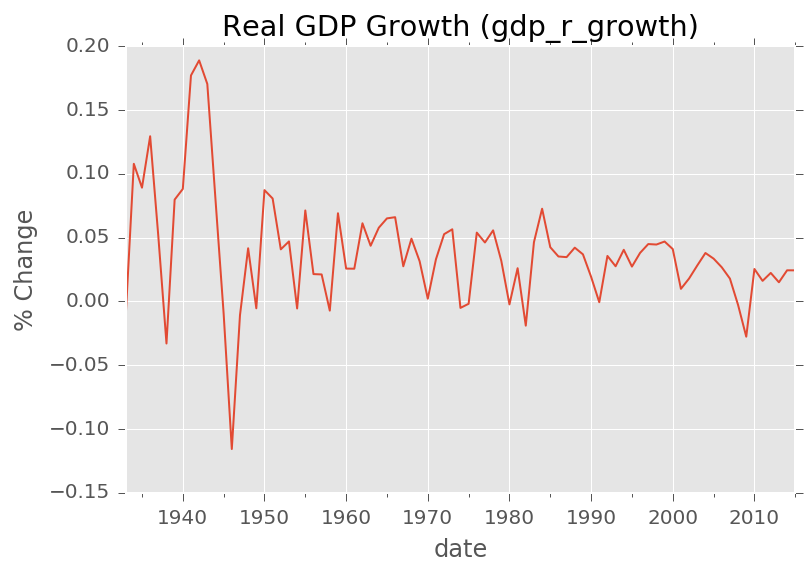

In [14]:
data['gdp_r_growth'].plot()
plt.title('Real GDP Growth (gdp_r_growth)')
plt.ylabel('% Change')
plt.show()

We find out the autocorrelation of real GDP growth. Turns out real GDP growth has pretty high autocorrelation on period 1.

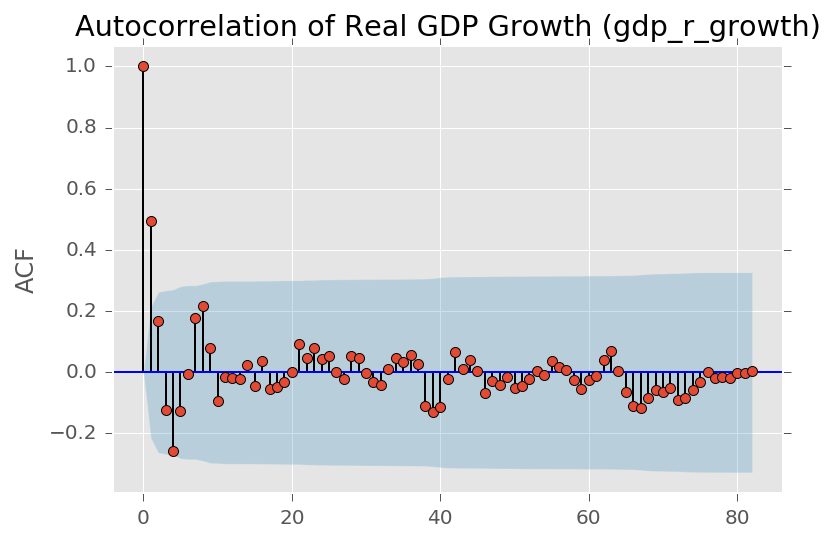

In [15]:
tsaplots.plot_acf(data['gdp_r_growth'])
plt.title('Autocorrelation of Real GDP Growth (gdp_r_growth)')
plt.ylabel('ACF')
plt.show()

If we ignore the autocorrelation and extra variables (such as `great_depression` and `ww2`) and simply regress `gdp_r_growth` on `dem_pres`, we get a regression with a really low $R^2$.

In [51]:
model = sm.ols(formula='''
gdp_r_growth ~ dem_pres
''', data=data)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           gdp_r_growth   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     3.568
Date:                Tue, 21 Jun 2016   Prob (F-statistic):             0.0625
Time:                        01:33:25   Log-Likelihood:                 144.04
No. Observations:                  83   AIC:                            -284.1
Df Residuals:                      81   BIC:                            -279.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0279      0.007      3.873      0.000       0.014       0.042
dem_pres       0.0181      0.010      1.889      0.062      -0.001       0.037
==============================================================================
Omnibus:                       15.122   Durbin-Watson:                   1.059
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               50.129
Skew:                           0.343   Prob(JB):                     1.30e-11
Kurtosis:                       6.745   Cond. No.                         2.80
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can also plot the residuals of the regression above. The residuals are clearly not normally distributed.

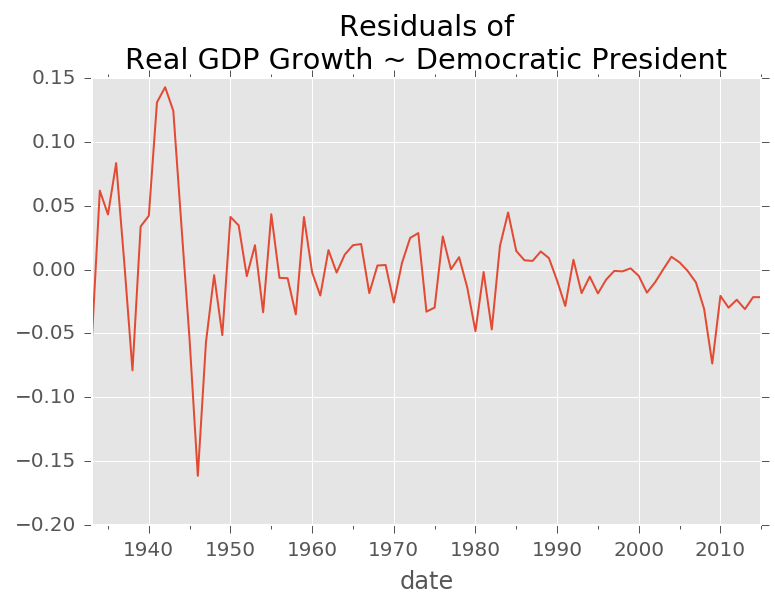

In [18]:
results.resid.plot()
plt.title('Residuals of\nReal GDP Growth ~ Democratic President')
plt.show()

We can also use scatter plots to visualize the relationship between real GDP growth and the three variables: `dem_pres`, `dem_senate_pct`, and `dem_house_pct`. We find inconclusive results for all of them.

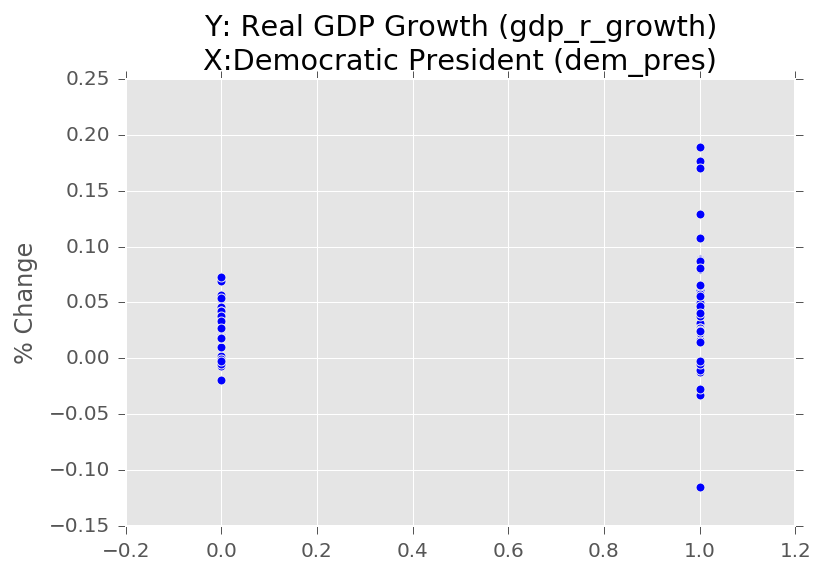

In [17]:
plt.scatter(y='gdp_r_growth', x='dem_pres', data=data)
plt.title('Y: Real GDP Growth (gdp_r_growth)\nX:Democratic President (dem_pres)')
plt.ylabel('% Change')
plt.show()

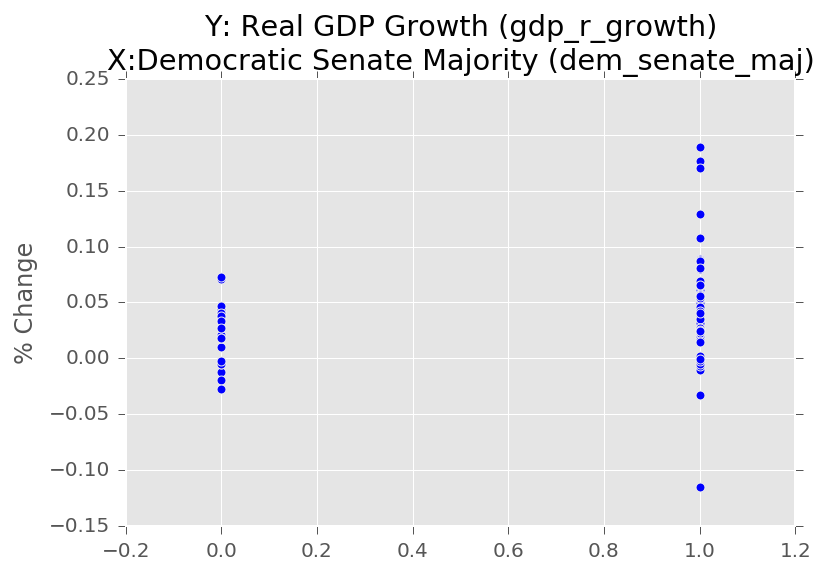

In [63]:
plt.scatter(y='gdp_r_growth', x='dem_senate_maj', data=data)
plt.title('Y: Real GDP Growth (gdp_r_growth)\nX:Democratic Senate Majority (dem_senate_maj)')
plt.ylabel('% Change')
plt.show()

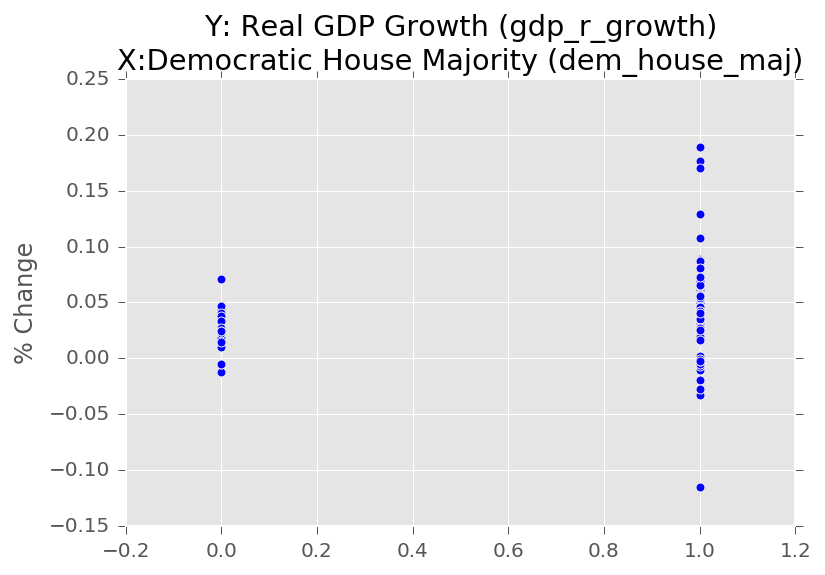

In [62]:
plt.scatter(y='gdp_r_growth', x='dem_house_maj', data=data)
plt.title('Y: Real GDP Growth (gdp_r_growth)\nX:Democratic House Majority (dem_house_maj)')
plt.ylabel('% Change')
plt.show()

We can run a more extensive multivariate regression. This accounts for the autoregressive nature of the `gdp_r_growth` time series, the Great Depression, World War 2, the three political variables, and permutations of the interaction of the 3 political variables. For example, one may argue that holding both the senate and the house, or all three -- presidency, senate, and house -- may facilitate execution of a party's views. Interacting the three variables allows us to test this argument.

In [64]:
model = sm.ols(formula='''
gdp_r_growth ~ gdp_r_growth_lag1 + great_depression + ww2 + dem_pres * dem_senate_maj * dem_house_maj
''', data=data)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           gdp_r_growth   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     5.129
Date:                Tue, 21 Jun 2016   Prob (F-statistic):           2.24e-05
Time:                        01:38:49   Log-Likelihood:                 162.58
No. Observations:                  83   AIC:                            -305.2
Df Residuals:                      73   BIC:                            -281.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
Intercept                                                 0.0187      0.012      1.503      0.137      -0.006       0.043
dem_senate_maj[T.True]                                   -0.0102      0.015     -0.682      0.497      -0.040       0.020
dem_house_maj[T.True]                                     0.0008      0.017      0.048      0.962      -0.033       0.034
dem_senate_maj[T.True]:dem_house_maj[T.True]              0.0109      0.015      0.726      0.470      -0.019       0.041
gdp_r_growth_lag1                                         0.2919      0.104      2.813      0.006       0.085       0.499
great_depression                                          0.0370      0.018      2.105      0.039       0.002       0.072
ww2                                                       0.0516      0.019      2.658      0.010       0.013       0.090
dem_pres                                                  0.0027      0.018      0.154      0.878      -0.033       0.038
dem_pres:dem_senate_maj[T.True]                           0.0045      0.015      0.305      0.761      -0.025       0.034
dem_pres:dem_house_maj[T.True]                           -0.0271      0.033     -0.811      0.420      -0.094       0.039
dem_pres:dem_senate_maj[T.True]:dem_house_maj[T.True]     0.0257      0.024      1.060      0.293      -0.023       0.074
==============================================================================
Omnibus:                       23.405   Durbin-Watson:                   1.725
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.992
Skew:                          -0.999   Prob(JB):                     3.79e-11
Kurtosis:                       6.144   Cond. No.                     1.77e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.05e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

We find that the political variables are rather insignificant in explaining real GDP growth.

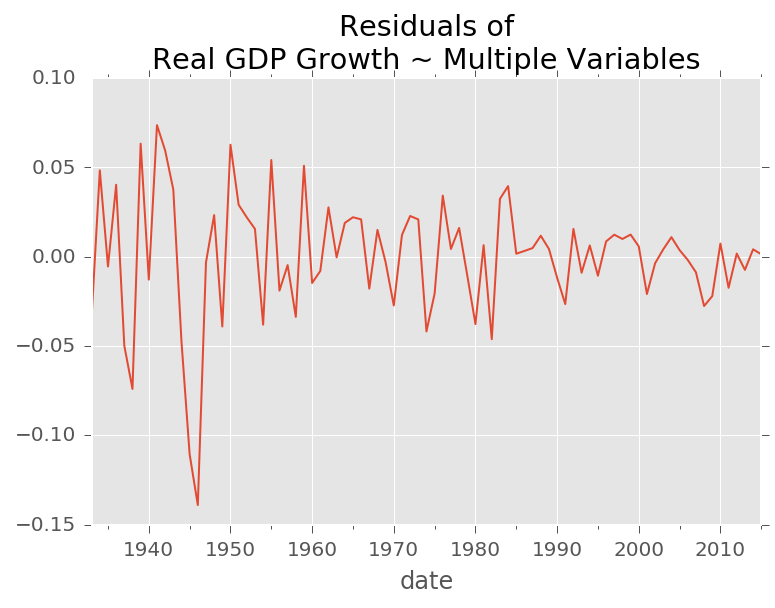

In [65]:
results.resid.plot()
plt.title('Residuals of\nReal GDP Growth ~ Multiple Variables')
plt.show()

## Defense Spending and Politics

We do the same analysis as above for `def_pct_gdp`.

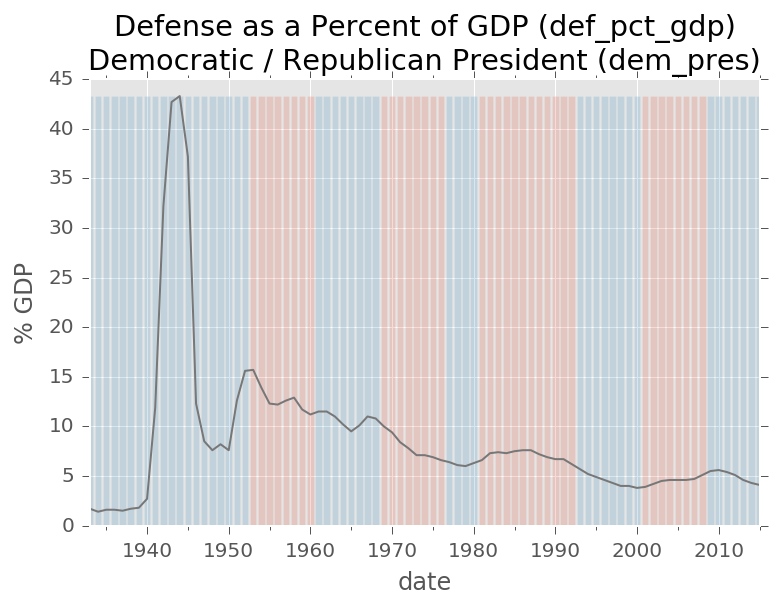

In [23]:
plot_line_with_background('def_pct_gdp', 'dem_pres', data, 
                          'Defense as a Percent of GDP (def_pct_gdp)\nDemocratic / Republican President (dem_pres)',
                          '% GDP')

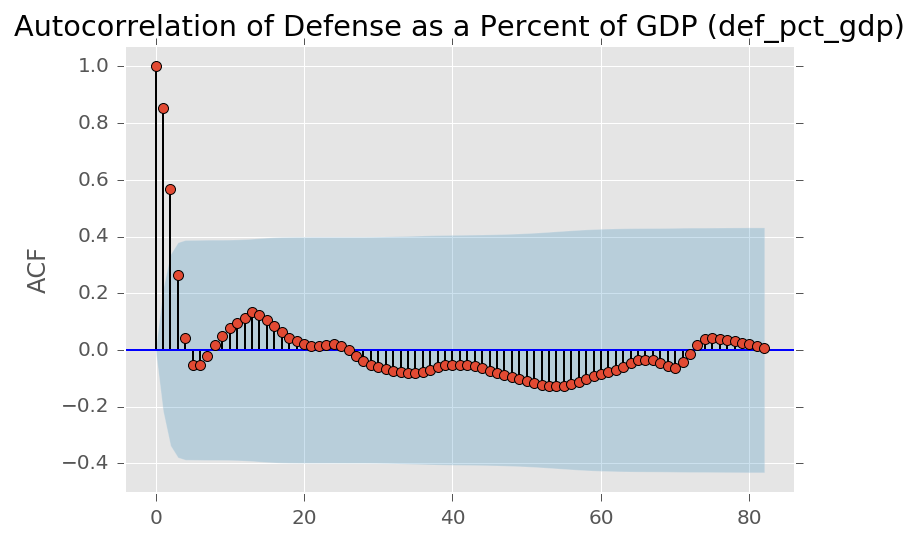

In [24]:
tsaplots.plot_acf(data['def_pct_gdp'])
plt.title('Autocorrelation of Defense as a Percent of GDP (def_pct_gdp)')
plt.ylabel('ACF')
plt.show()

This time we find that `def_pct_gdp` is autoregressive up to around period 2. Hence we lag `def_pct_gdp` by up to two periods in the multivariate regression later.

In [25]:
model = sm.ols(formula='''
def_pct_gdp ~ dem_pres
''', data=data)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            def_pct_gdp   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.5700
Date:                Tue, 21 Jun 2016   Prob (F-statistic):              0.452
Time:                        01:28:56   Log-Likelihood:                -286.17
No. Observations:                  83   AIC:                             576.3
Df Residuals:                      81   BIC:                             581.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.9722      1.283      6.213      0.000       5.419      10.525
dem_pres       1.2874      1.705      0.755      0.452      -2.105       4.680
==============================================================================
Omnibus:                       74.398   Durbin-Watson:                   0.280
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              442.934
Skew:                           2.927   Prob(JB):                     6.58e-97
Kurtosis:                      12.685   Cond. No.                         2.80
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

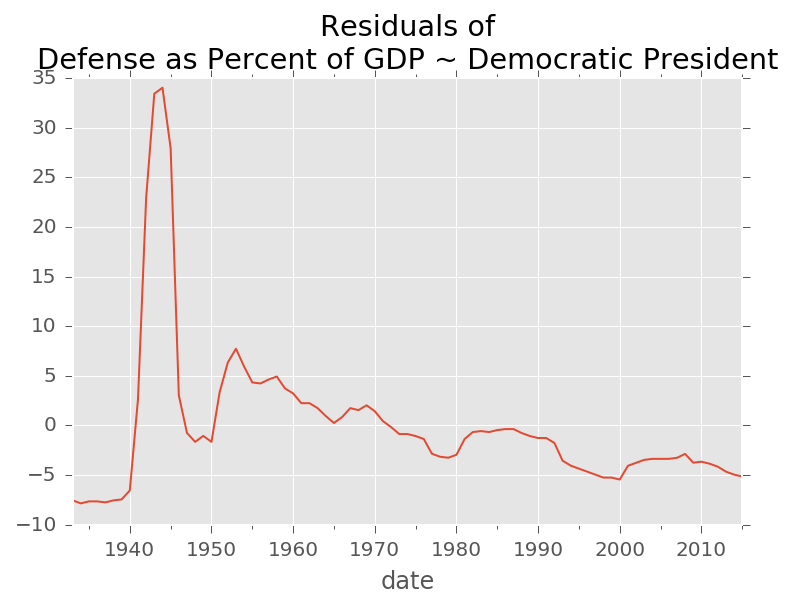

In [26]:
results.resid.plot()
plt.title('Residuals of\nDefense as Percent of GDP ~ Democratic President')
plt.show()

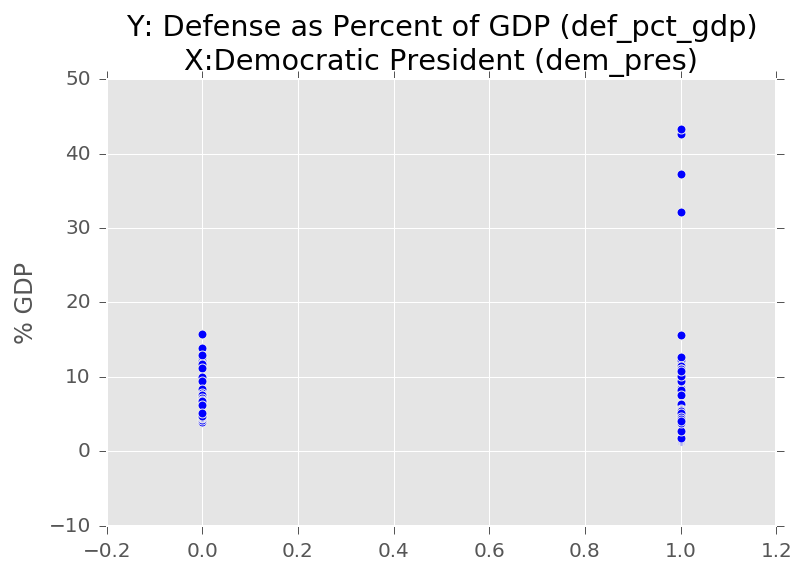

In [27]:
plt.scatter(y='def_pct_gdp', x='dem_pres', data=data)
plt.title('Y: Defense as Percent of GDP (def_pct_gdp)\nX:Democratic President (dem_pres)')
plt.ylabel('% GDP')
plt.show()

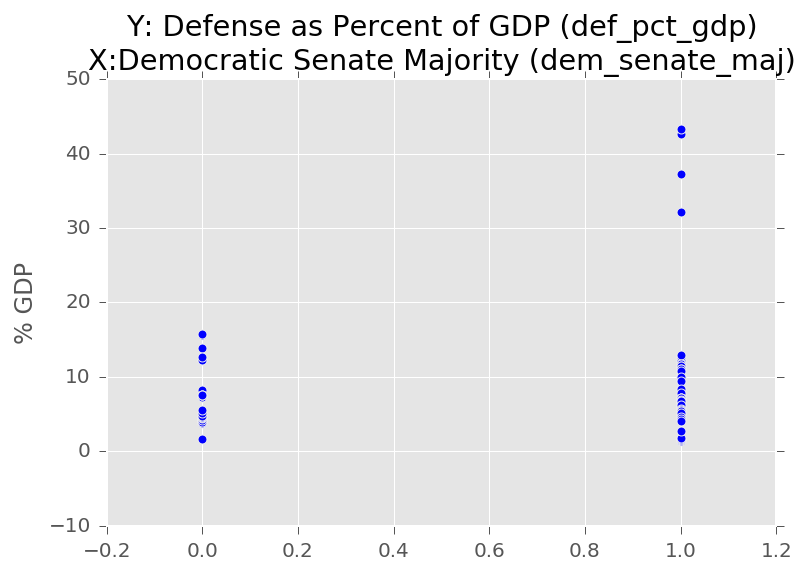

In [66]:
plt.scatter(y='def_pct_gdp', x='dem_senate_maj', data=data)
plt.title('Y: Defense as Percent of GDP (def_pct_gdp)\nX:Democratic Senate Majority (dem_senate_maj)')
plt.ylabel('% GDP')
plt.show()

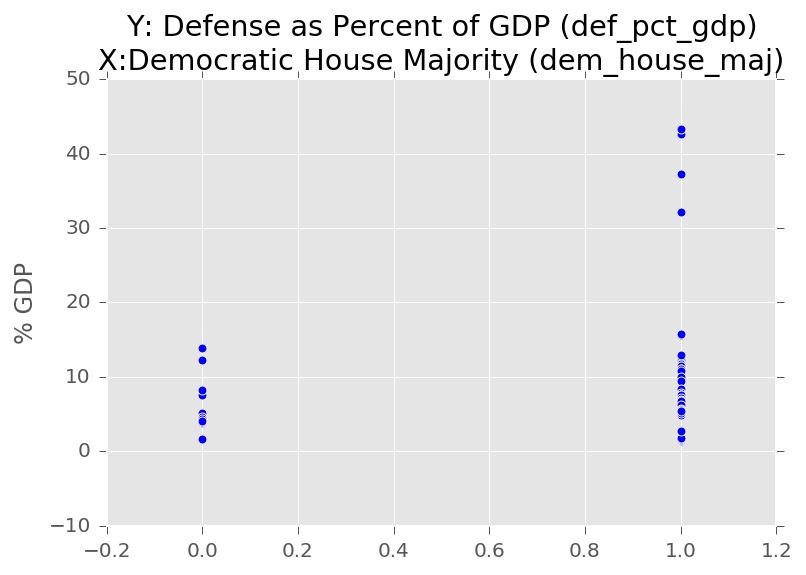

In [68]:
plt.scatter(y='def_pct_gdp', x='dem_house_maj', data=data)
plt.title('Y: Defense as Percent of GDP (def_pct_gdp)\nX:Democratic House Majority (dem_house_maj)')
plt.ylabel('% GDP')
plt.show()

In [69]:
model = sm.ols(formula='''
def_pct_gdp ~ def_pct_gdp_lag1 + def_pct_gdp_lag2 + great_depression + ww2 + dem_pres * dem_senate_maj * dem_house_maj
''', data=data)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            def_pct_gdp   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     18.10
Date:                Tue, 21 Jun 2016   Prob (F-statistic):           5.61e-16
Time:                        01:41:50   Log-Likelihood:                -234.30
No. Observations:                  83   AIC:                             490.6
Df Residuals:                      72   BIC:                             517.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
Intercept                                                 6.0241      1.458      4.131      0.000       3.117       8.931
dem_senate_maj[T.True]                                   -0.4666      1.802     -0.259      0.796      -4.059       3.126
dem_house_maj[T.True]                                     2.4422      2.009      1.216      0.228      -1.563       6.447
dem_senate_maj[T.True]:dem_house_maj[T.True]              0.4403      1.813      0.243      0.809      -3.173       4.054
def_pct_gdp_lag1                                          1.6643      1.437      1.158      0.251      -1.200       4.529
def_pct_gdp_lag2                                          7.7138      1.445      5.338      0.000       4.833      10.594
great_depression                                         -6.9399      2.122     -3.271      0.002     -11.170      -2.710
ww2                                                      10.6150      2.739      3.875      0.000       5.154      16.076
dem_pres                                                  0.8250      2.160      0.382      0.704      -3.480       5.130
dem_pres:dem_senate_maj[T.True]                          -1.4215      1.798     -0.791      0.432      -5.006       2.163
dem_pres:dem_house_maj[T.True]                            0.8389      4.047      0.207      0.836      -7.228       8.906
dem_pres:dem_senate_maj[T.True]:dem_house_maj[T.True]    -0.5146      2.937     -0.175      0.861      -6.369       5.340
==============================================================================
Omnibus:                       17.056   Durbin-Watson:                   0.740
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               87.957
Skew:                           0.054   Prob(JB):                     7.95e-20
Kurtosis:                       8.042   Cond. No.                     1.94e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.73e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Once again the political variables seem to be statistically insignificant.

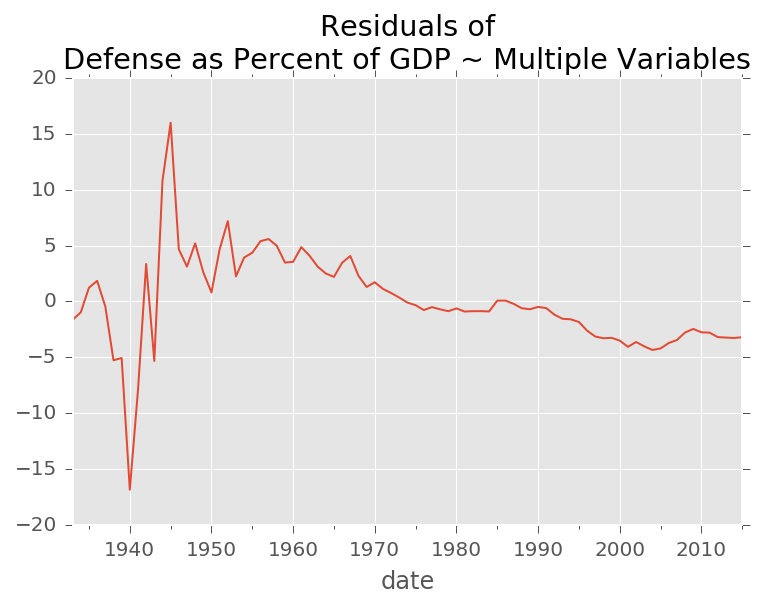

In [31]:
results.resid.plot()
plt.title('Residuals of\nDefense as Percent of GDP ~ Multiple Variables')
plt.show()

## Federal Surplus and Politics

We do the same analysis for `fed_sur_pct_gdp`, federal surplus as a percent of GDP.

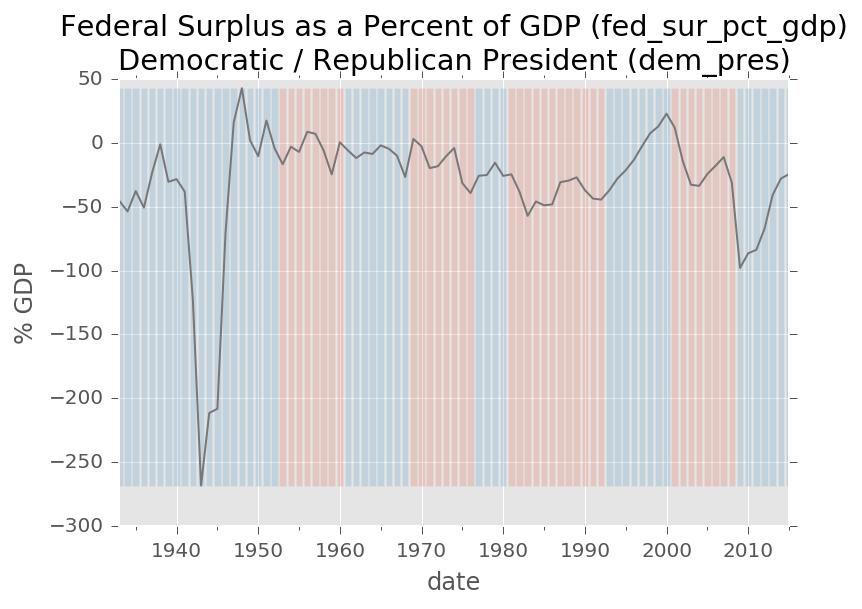

In [32]:
plot_line_with_background('fed_sur_pct_gdp', 'dem_pres', data, 
                          'Federal Surplus as a Percent of GDP (fed_sur_pct_gdp)\nDemocratic / Republican President (dem_pres)',
                          '% GDP')

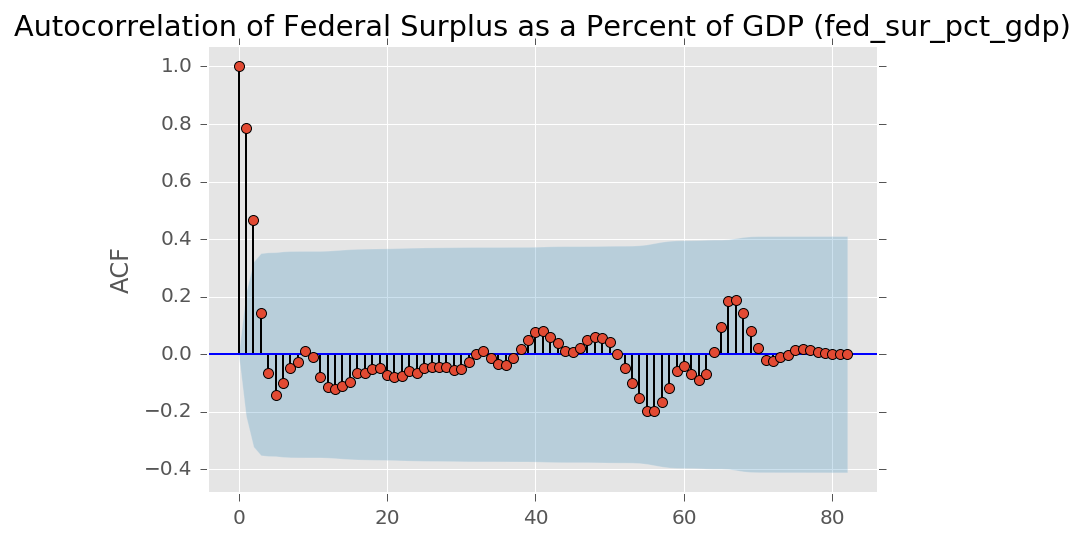

In [33]:
tsaplots.plot_acf(data['fed_sur_pct_gdp'])
plt.title('Autocorrelation of Federal Surplus as a Percent of GDP (fed_sur_pct_gdp)')
plt.ylabel('ACF')
plt.show()

In [34]:
model = sm.ols(formula='''
fed_sur_pct_gdp ~ dem_pres
''', data=data)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        fed_sur_pct_gdp   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     2.360
Date:                Tue, 21 Jun 2016   Prob (F-statistic):              0.128
Time:                        01:29:15   Log-Likelihood:                -436.17
No. Observations:                  83   AIC:                             876.3
Df Residuals:                      81   BIC:                             881.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -21.9831      7.819     -2.812      0.006     -37.540      -6.427
dem_pres     -15.9617     10.390     -1.536      0.128     -36.635       4.711
==============================================================================
Omnibus:                       69.116   Durbin-Watson:                   0.442
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              406.406
Skew:                          -2.637   Prob(JB):                     5.62e-89
Kurtosis:                      12.471   Cond. No.                         2.80
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

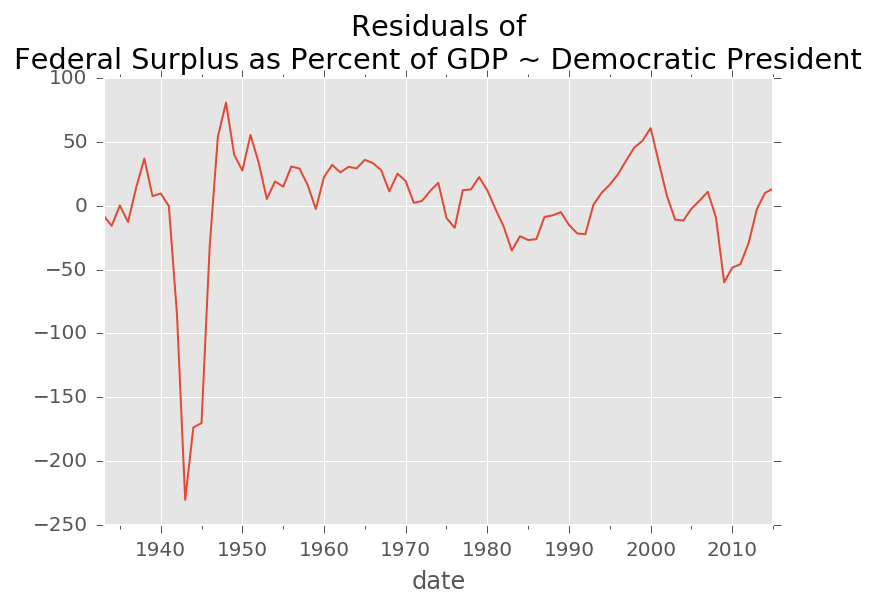

In [35]:
results.resid.plot()
plt.title('Residuals of\nFederal Surplus as Percent of GDP ~ Democratic President')
plt.show()

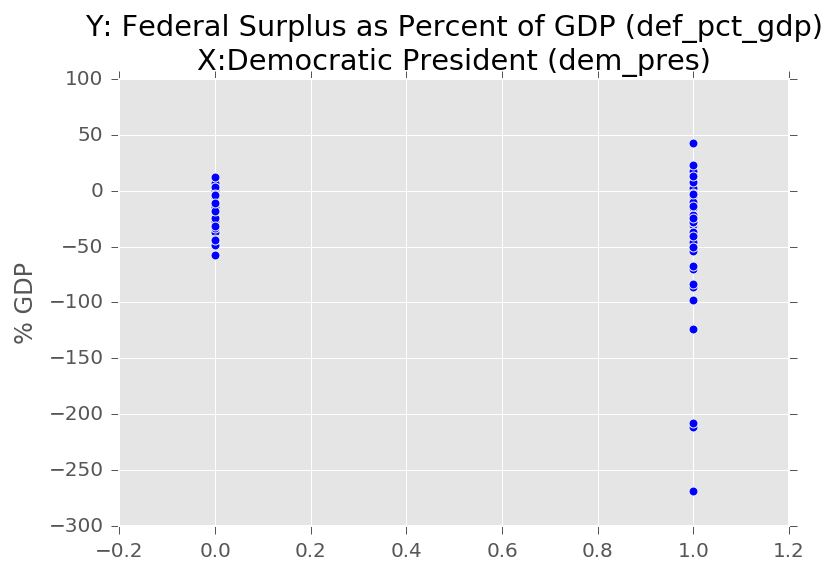

In [36]:
plt.scatter(y='fed_sur_pct_gdp', x='dem_pres', data=data)
plt.title('Y: Federal Surplus as Percent of GDP (def_pct_gdp)\nX:Democratic President (dem_pres)')
plt.ylabel('% GDP')
plt.show()

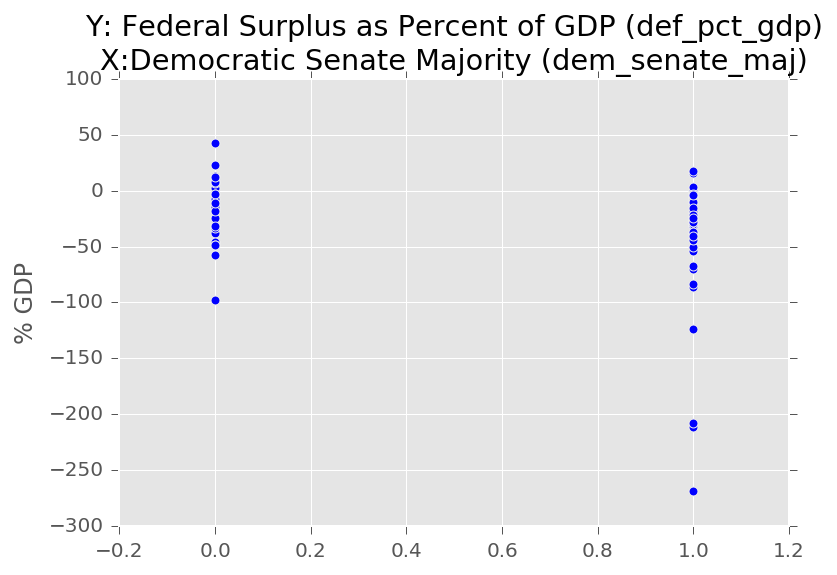

In [70]:
plt.scatter(y='fed_sur_pct_gdp', x='dem_senate_maj', data=data)
plt.title('Y: Federal Surplus as Percent of GDP (def_pct_gdp)\nX:Democratic Senate Majority (dem_senate_maj)')
plt.ylabel('% GDP')
plt.show()

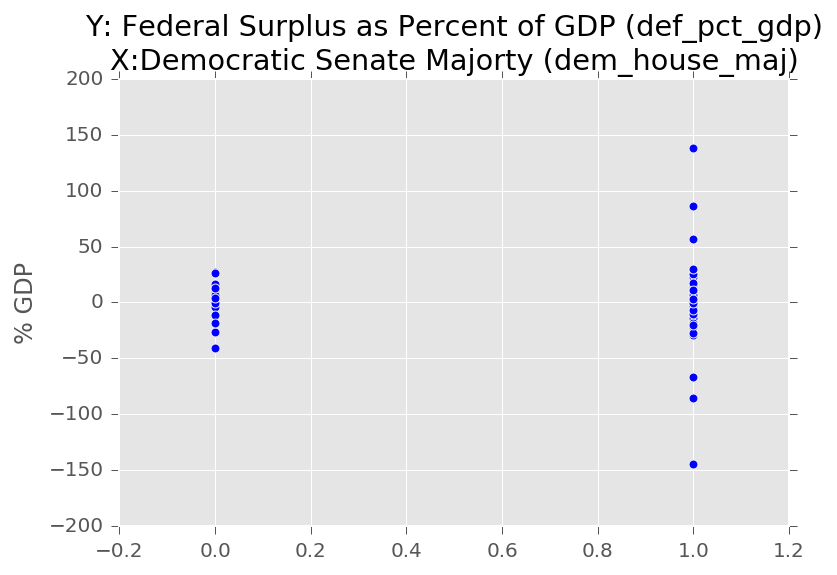

In [71]:
plt.scatter(y='fed_sur_pct_gdp_growth', x='dem_house_maj', data=data)
plt.title('Y: Federal Surplus as Percent of GDP (def_pct_gdp)\nX:Democratic Senate Majorty (dem_house_maj)')
plt.ylabel('% GDP')
plt.show()

In [72]:
model = sm.ols(formula='''
fed_sur_pct_gdp ~ great_depression + ww2 + dem_pres * dem_senate_maj * dem_house_maj
''', data=data)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        fed_sur_pct_gdp   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     10.81
Date:                Tue, 21 Jun 2016   Prob (F-statistic):           6.07e-10
Time:                        01:43:24   Log-Likelihood:                -405.24
No. Observations:                  83   AIC:                             828.5
Df Residuals:                      74   BIC:                             850.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
Intercept                                               -14.6692     11.271     -1.301      0.197     -37.128       7.789
dem_senate_maj[T.True]                                  -26.5089     13.915     -1.905      0.061     -54.234       1.216
dem_house_maj[T.True]                                   -15.4206     15.536     -0.993      0.324     -46.378      15.536
dem_senate_maj[T.True]:dem_house_maj[T.True]             35.5122     13.915      2.552      0.013       7.787      63.238
great_depression                                        -26.9518     16.340     -1.649      0.103     -59.510       5.606
ww2                                                    -125.6668     15.452     -8.133      0.000    -156.456     -94.877
dem_pres                                                 21.4570     16.557      1.296      0.199     -11.534      54.448
dem_pres:dem_senate_maj[T.True]                         -20.3856     13.825     -1.475      0.145     -47.933       7.162
dem_pres:dem_house_maj[T.True]                          -42.4208     30.987     -1.369      0.175    -104.163      19.321
dem_pres:dem_senate_maj[T.True]:dem_house_maj[T.True]    41.6354     22.495      1.851      0.068      -3.187      86.458
==============================================================================
Omnibus:                       15.808   Durbin-Watson:                   0.889
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               72.261
Skew:                           0.068   Prob(JB):                     2.04e-16
Kurtosis:                       7.569   Cond. No.                     2.04e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.93e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

We find statistically significant results for the interaction of `dem_senate_maj` and `dem_house_maj`. In other words, a combined democratic senate and house seem to be correlated with higher defense spendings. However, this may be very skewed by the inclusion of the World War 2 years.

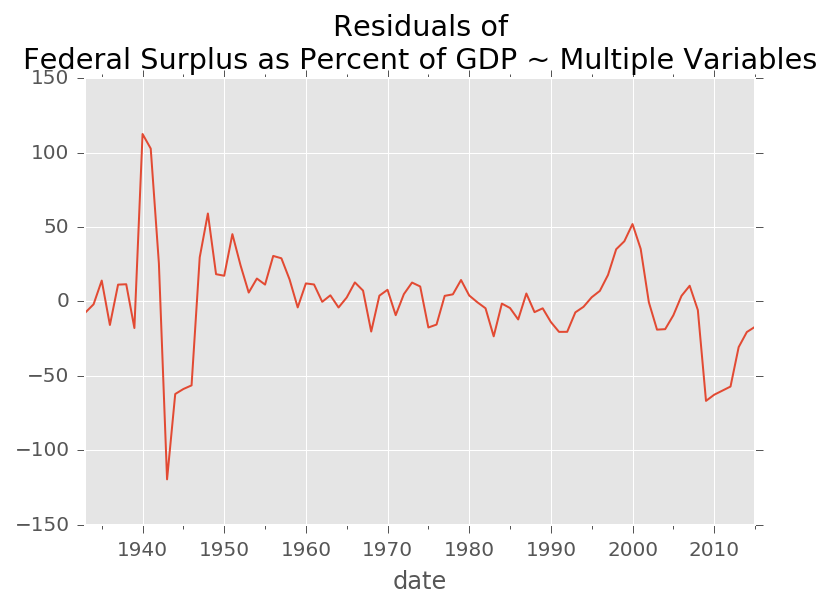

In [40]:
results.resid.plot()
plt.title('Residuals of\nFederal Surplus as Percent of GDP ~ Multiple Variables')
plt.show()

## Federal Surplus (Differenced) and Politics

We do the same analysis for the differenced time series of federal surplus as a percent of GDP. `fed_sur_pct_gdp_growth`.

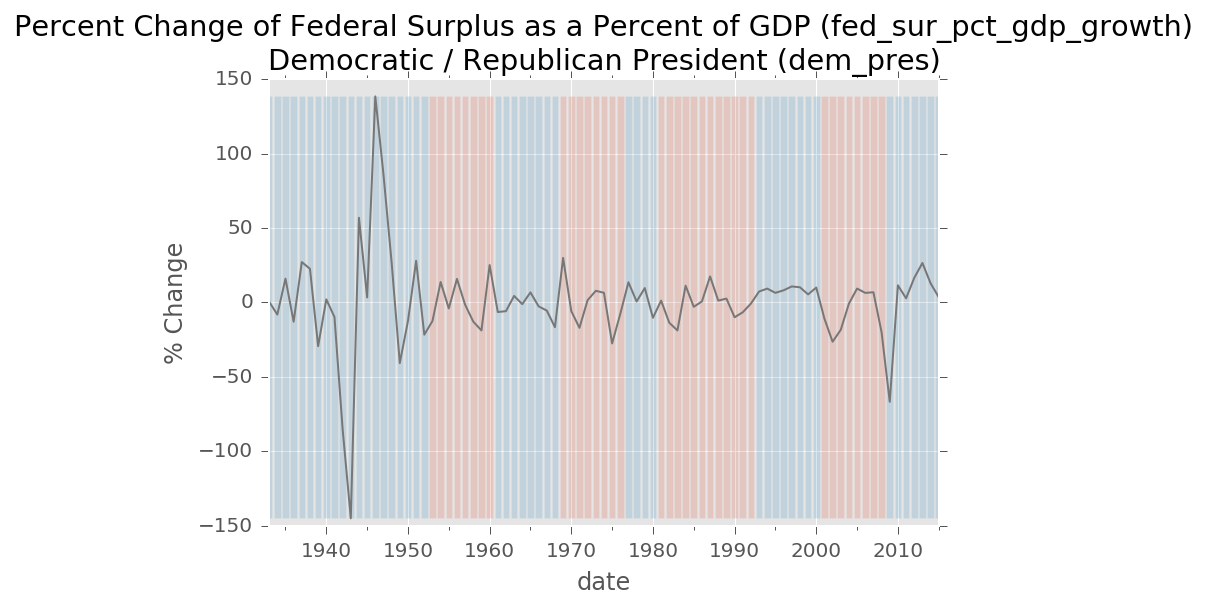

In [41]:
plot_line_with_background('fed_sur_pct_gdp_growth', 'dem_pres', data, 
                          'Percent Change of Federal Surplus as a Percent of GDP (fed_sur_pct_gdp_growth)\nDemocratic / Republican President (dem_pres)',
                          '% Change')

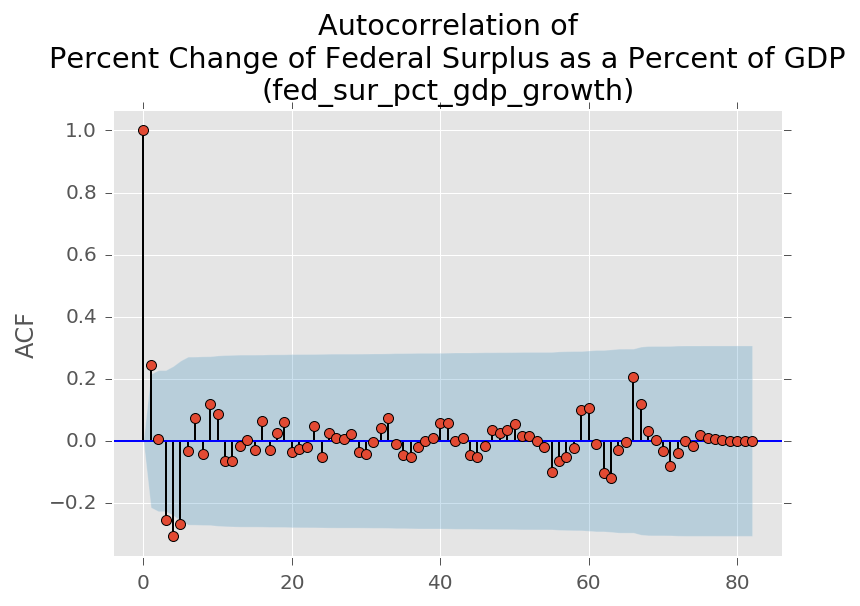

In [42]:
tsaplots.plot_acf(data['fed_sur_pct_gdp_growth'])
plt.title('Autocorrelation of\nPercent Change of Federal Surplus as a Percent of GDP\n(fed_sur_pct_gdp_growth)')
plt.ylabel('ACF')
plt.show()

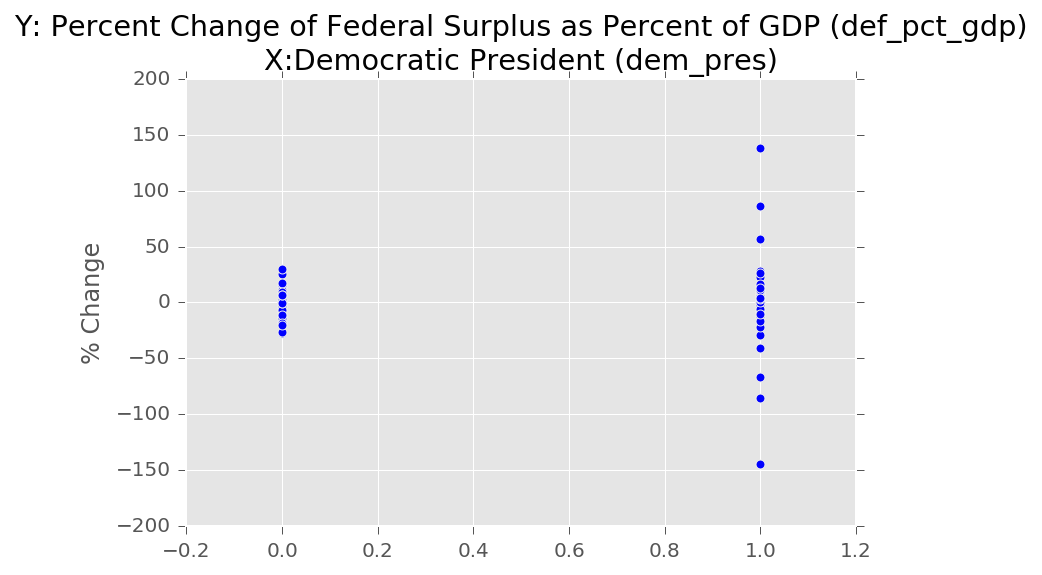

In [43]:
plt.scatter(y='fed_sur_pct_gdp_growth', x='dem_pres', data=data)
plt.title('Y: Percent Change of Federal Surplus as Percent of GDP (def_pct_gdp)\nX:Democratic President (dem_pres)')
plt.ylabel('% Change')
plt.show()

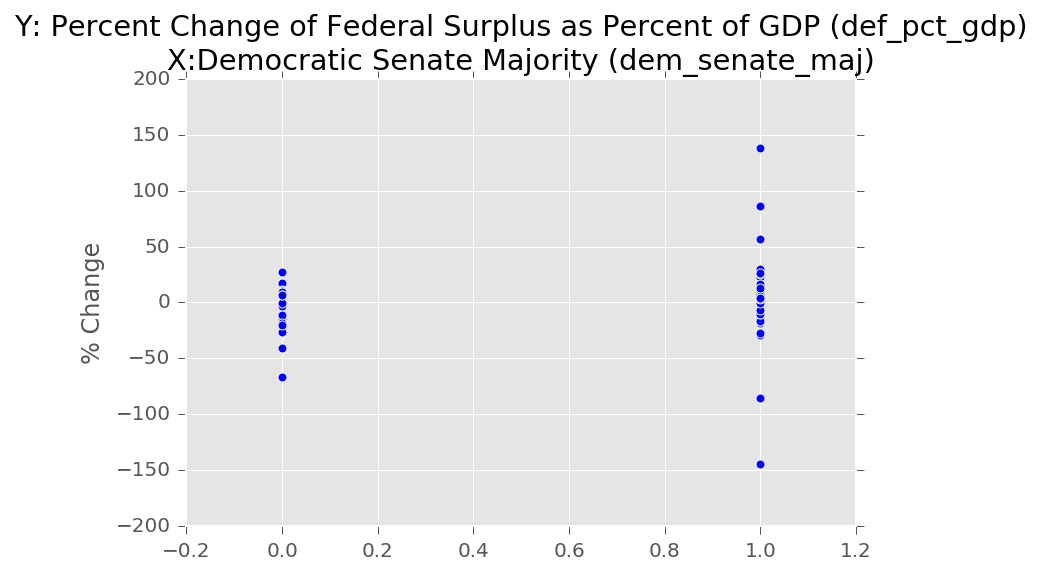

In [74]:
plt.scatter(y='fed_sur_pct_gdp_growth', x='dem_senate_maj', data=data)
plt.title('Y: Percent Change of Federal Surplus as Percent of GDP (def_pct_gdp)\nX:Democratic Senate Majority (dem_senate_maj)')
plt.ylabel('% Change')
plt.show()

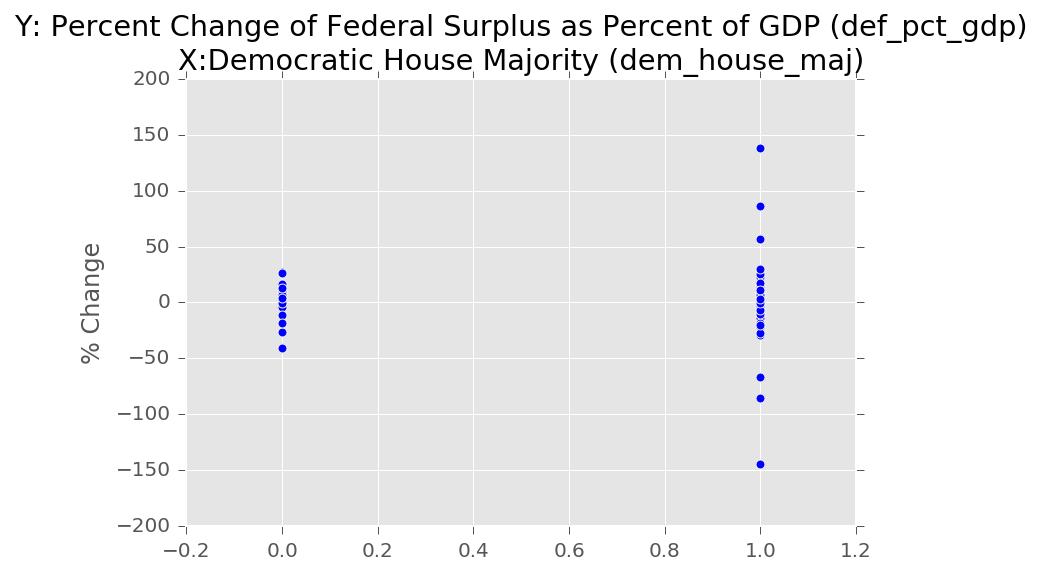

In [73]:
plt.scatter(y='fed_sur_pct_gdp_growth', x='dem_house_maj', data=data)
plt.title('Y: Percent Change of Federal Surplus as Percent of GDP (def_pct_gdp)\nX:Democratic House Majority (dem_house_maj)')
plt.ylabel('% Change')
plt.show()

In [75]:
model = sm.ols(formula='''
fed_sur_pct_gdp_growth ~ great_depression + ww2 + dem_pres * dem_senate_maj * dem_house_maj
''', data=data)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     fed_sur_pct_gdp_growth   R-squared:                       0.170
Model:                                OLS   Adj. R-squared:                  0.080
Method:                     Least Squares   F-statistic:                     1.895
Date:                    Tue, 21 Jun 2016   Prob (F-statistic):             0.0734
Time:                            01:45:31   Log-Likelihood:                -394.45
No. Observations:                      83   AIC:                             806.9
Df Residuals:                          74   BIC:                             828.7
Df Model:                               8                                         
Covariance Type:                nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
Intercept                                                -2.7145      9.897     -0.274      0.785     -22.435      17.006
dem_senate_maj[T.True]                                   -8.3914     12.218     -0.687      0.494     -32.737      15.954
dem_house_maj[T.True]                                     0.2616     13.642      0.019      0.985     -26.921      27.444
dem_senate_maj[T.True]:dem_house_maj[T.True]              8.9821     12.218      0.735      0.465     -15.363      33.327
great_depression                                         -5.3059     14.348     -0.370      0.713     -33.895      23.283
ww2                                                     -40.7552     13.568     -3.004      0.004     -67.791     -13.720
dem_pres                                                  7.2386     14.538      0.498      0.620     -21.730      36.207
dem_pres:dem_senate_maj[T.True]                          18.6973     12.140      1.540      0.128      -5.492      42.887
dem_pres:dem_house_maj[T.True]                          -49.0469     27.209     -1.803      0.076    -103.262       5.168
dem_pres:dem_senate_maj[T.True]:dem_house_maj[T.True]    36.0709     19.753      1.826      0.072      -3.287      75.429
==============================================================================
Omnibus:                       30.138   Durbin-Watson:                   1.625
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              216.448
Skew:                           0.717   Prob(JB):                     9.98e-48
Kurtosis:                      10.780   Cond. No.                     2.04e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.93e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

This regression by itself has a rather low $R^2$. On top of that, the political variables all seem statistically insignificant.

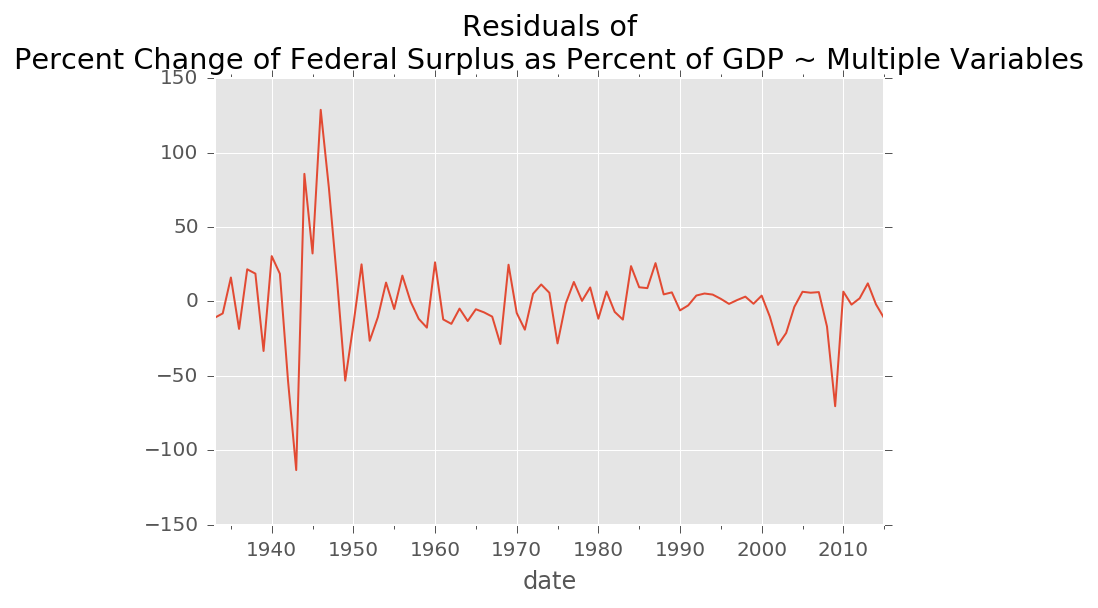

In [47]:
results.resid.plot()
plt.title('Residuals of\nPercent Change of Federal Surplus as Percent of GDP ~ Multiple Variables')
plt.show()